In [14]:
import os
import pickle
import time
from glob import glob
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from lzw import compress

BASE_PATH = os.path.join("datasets", "parte2")

**Criação do DataFrame**

In [2]:
faces_folders = sorted(
    glob(os.path.join(BASE_PATH, "orl_faces", "*")),
    key=lambda x: int(x.rsplit("s", maxsplit=1)[1]),
)

faces_dict = {}
for dir in faces_folders:
    faces_dict[dir.rsplit("/", maxsplit=1)[1]] = sorted(
        os.listdir(dir), key=lambda x: int(x.split(".")[0])
    )

faces_df = pd.DataFrame(faces_dict)
print(f"Dimensões do DataFrame: {faces_df.shape}")
faces_df.iloc[:, :5]


Dimensões do DataFrame: (10, 40)


,s1,s2,s3,s4,s5
0,1.pgm,1.pgm,1.pgm,1.pgm,1.pgm
1,2.pgm,2.pgm,2.pgm,2.pgm,2.pgm
2,3.pgm,3.pgm,3.pgm,3.pgm,3.pgm
3,4.pgm,4.pgm,4.pgm,4.pgm,4.pgm
4,5.pgm,5.pgm,5.pgm,5.pgm,5.pgm
5,6.pgm,6.pgm,6.pgm,6.pgm,6.pgm
6,7.pgm,7.pgm,7.pgm,7.pgm,7.pgm
7,8.pgm,8.pgm,8.pgm,8.pgm,8.pgm
8,9.pgm,9.pgm,9.pgm,9.pgm,9.pgm
9,10.pgm,10.pgm,10.pgm,10.pgm,10.pgm


**Separando o DataFrame em Treino/Teste de maneira aleatória**

In [3]:
shuffled_faces_df = faces_df.copy()
random_state = 1

for col in shuffled_faces_df.columns:
    shuffled_faces_df.loc[:, col] = (
        shuffled_faces_df.loc[:, col]
        .sample(frac=1, random_state=random_state)
        .to_numpy()
    )
    random_state += 1


In [4]:
faces_df_train = shuffled_faces_df.iloc[:-1]
print(f"Dimensões do DataFrame de Treino: {faces_df_train.shape}")
faces_df_train.iloc[:, :5]

Dimensões do DataFrame de Treino: (9, 40)


,s1,s2,s3,s4,s5
0,3.pgm,5.pgm,6.pgm,4.pgm,10.pgm
1,10.pgm,2.pgm,5.pgm,9.pgm,6.pgm
2,7.pgm,6.pgm,2.pgm,5.pgm,3.pgm
3,5.pgm,1.pgm,3.pgm,10.pgm,5.pgm
4,1.pgm,8.pgm,10.pgm,3.pgm,8.pgm
5,4.pgm,3.pgm,7.pgm,7.pgm,2.pgm
6,2.pgm,4.pgm,8.pgm,1.pgm,1.pgm
7,8.pgm,7.pgm,1.pgm,2.pgm,9.pgm
8,9.pgm,10.pgm,4.pgm,6.pgm,7.pgm


In [5]:
faces_df_test = shuffled_faces_df.iloc[-1:]
print(f"Dimensões do DataFrame de Teste: {faces_df_test.shape}")
faces_df_test.iloc[:, :5]

Dimensões do DataFrame de Teste: (1, 40)


,s1,s2,s3,s4,s5
9,6.pgm,9.pgm,9.pgm,8.pgm,4.pgm


**Treinamento**

In [6]:
tempo_de_treinamento = {k: 0 for k in range(9, 17)}

for k in tqdm(range(9, 17), "Realizando o treinamento do modelo..."):
    start = time.time()

    for col in faces_df_train.columns:
        category_dict = {}

        for image in faces_df_train.loc[:, col]:
            category_dict = compress(
                file_path=os.path.join(BASE_PATH, "orl_faces", col, image),
                k=k,
                dictionary=category_dict,
                is_training=True,
                is_PGM=True,
            )

        dict_path = os.path.join(BASE_PATH, "dicts", str(k))
        if not os.path.exists(dict_path):
            os.makedirs(dict_path)

        with open(os.path.join(dict_path, f"{col}_dict.pkl"), "wb") as pkl_file:
            pickle.dump(category_dict, pkl_file, pickle.HIGHEST_PROTOCOL)

    tempo_de_treinamento[k] = time.time() - start

with open(os.path.join(BASE_PATH, "tempo_de_treinamento.pkl"), "wb") as pkl_file:
    pickle.dump(tempo_de_treinamento, pkl_file, pickle.HIGHEST_PROTOCOL)


Realizando o treinamento do modelo...: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


**Compressão das Imagens de Teste com base nos dicionários gerados no treinamento**

In [7]:
for k in tqdm(range(9, 17), "Realizando o treinamento do modelo..."):
    for idx, image_col in enumerate(faces_df_test.columns):
        image = faces_df_test.iat[0, idx]
        
        for dict_col in faces_df_test.columns:
            with open(
                os.path.join(BASE_PATH, "dicts", str(k), f"{dict_col}_dict.pkl"), "rb"
            ) as dict_file:
                category_dict = pickle.load(dict_file)
            
            compress(
                file_path=os.path.join(BASE_PATH, "orl_faces", image_col, image),
                k=k,
                dictionary=category_dict,
                out_path=os.path.join(
                    BASE_PATH,
                    "test_images",
                    image_col,
                    str(k),
                    f"{dict_col}_dict",
                    f"{image.split('.')[0]}_compressed.pgm",
                ),
                is_testing=True,
                is_PGM=True,
            )


Realizando o treinamento do modelo...: 100%|██████████| 8/8 [03:37<00:00, 27.17s/it]


**Aplicando o KNN para cada K do LZW**

In [19]:
MAX_IMAGE_SIZE = 999999999
y_true = faces_df_test.columns
accuracies = []

for k in range(9,17):
    y_pred = []
    
    for idx, col in enumerate(faces_df_test.columns):
        min_image_size = MAX_IMAGE_SIZE
        max_compression_dict = None

        test_image = faces_df_test.iat[0, idx]
        training_dicts = sorted(
            os.listdir(os.path.join(BASE_PATH, "test_images", col, str(k))),
            key= lambda x: int(x.split("s")[1].split("_")[0])
        )

        for training_dict in training_dicts:
            compressed_image_size = os.path.getsize(
                os.path.join(
                    BASE_PATH,
                    "test_images",
                    col,
                    str(k),
                    training_dict,
                    f"{test_image.split('.')[0]}_compressed.pgm",
                )
            )

            if compressed_image_size < min_image_size:
                min_image_size = compressed_image_size
                max_compression_dict = training_dict.split("_")[0]

        y_pred.append(max_compression_dict)

    accuracies.append(accuracy_score(y_true, y_pred))


**Tempo x K**

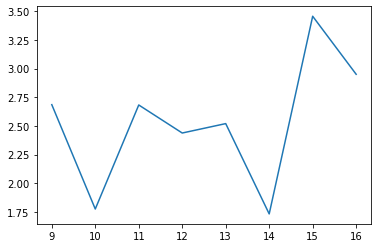

In [17]:
with open(os.path.join(BASE_PATH, "tempo_de_treinamento.pkl"), "rb") as dict_file:
    tempo_de_treinamento = pickle.load(dict_file)
    
plt.plot(tempo_de_treinamento.keys(), tempo_de_treinamento.values())

**Acurácia x K**

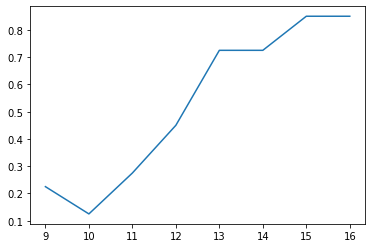

In [20]:
plt.plot(list(range(9,17)), accuracies)